In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet50
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ---------------- Dataset ----------------
class TrafficSignDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

with open("train_tensor_data.pkl", "rb") as f:
    train_data = pickle.load(f)
with open("test_tensor_data.pkl", "rb") as f:
    test_data = pickle.load(f)

# Wrap as Dataset
full_train_dataset = TrafficSignDataset(train_data)
test_dataset = TrafficSignDataset(test_data)

# Split train/val
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [4]:
def train_model(model, epochs=5, lr=1e-3, unfreeze=False):
    if unfreeze:
        for param in list(model.parameters())[-20:]:
            param.requires_grad = True
    else:
        for param in model.parameters():
            param.requires_grad = False

    # Always unfreeze final FC
    for param in model.fc.parameters():
        param.requires_grad = True

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    best_train_acc = 0
    best_val_acc = 0
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            correct += (preds.argmax(1) == y).sum().item()
            total += y.size(0)
        acc = correct / total
        train_accs.append(acc)
        best_train_acc = max(best_train_acc, acc)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                correct += (preds.argmax(1) == y).sum().item()
                total += y.size(0)
        acc = correct / total
        val_accs.append(acc)
        best_val_acc = max(best_val_acc, acc)

    return train_accs, val_accs, best_train_acc, best_val_acc


In [5]:
# ---------------- Phase 1: Frozen ----------------
model1 = resnet50(pretrained=True)
model1.fc = nn.Linear(model1.fc.in_features, 23)
model1.to(device)

train_accs1, val_accs1, best_train1, best_val1 = train_model(model1, epochs=5, lr=1e-3, unfreeze=False)

# ---------------- Phase 2: Fine-tune ----------------
model2 = resnet50(pretrained=True)
model2.fc = nn.Linear(model2.fc.in_features, 23)
model2.to(device)
model2.load_state_dict(model1.state_dict())  # load weights from phase 1

train_accs2, val_accs2, best_train2, best_val2 = train_model(model2, epochs=5, lr=1e-4, unfreeze=True)

/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/salman/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 26.0MB/s]
Epoch 5/5: 100%|██████████| 98/98 [00:14<00:00,  6.92it/s]


In [6]:
# ---------------- Test Accuracy ----------------
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            correct += (preds.argmax(1) == y).sum().item()
            total += y.size(0)
    return correct / total

test_acc1 = evaluate(model1, test_loader)
test_acc2 = evaluate(model2, test_loader)

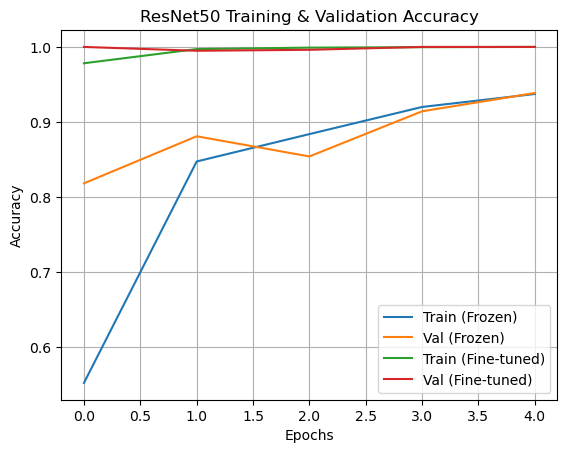

In [7]:
# ---------------- Plot ----------------
plt.plot(train_accs1, label="Train (Frozen)")
plt.plot(val_accs1, label="Val (Frozen)")
plt.plot(train_accs2, label="Train (Fine-tuned)")
plt.plot(val_accs2, label="Val (Fine-tuned)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ResNet50 Training & Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# ---------------- Report ----------------
print(f"Best Train Accuracy (Frozen):     {best_train1:.4f}")
print(f"Best Val Accuracy (Frozen):       {best_val1:.4f}")
print(f"Test Accuracy (Frozen):           {test_acc1:.4f}")
print()
print(f"Best Train Accuracy (Fine-tuned): {best_train2:.4f}")
print(f"Best Val Accuracy (Fine-tuned):   {best_val2:.4f}")
print(f"Test Accuracy (Fine-tuned):       {test_acc2:.4f}")

Best Train Accuracy (Frozen):     0.9373
Best Val Accuracy (Frozen):       0.9386
Test Accuracy (Frozen):           0.9209

Best Train Accuracy (Fine-tuned): 1.0000
Best Val Accuracy (Fine-tuned):   1.0000
Test Accuracy (Fine-tuned):       0.9990
